In [1]:
#Libriaries & Models
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from scipy.spatial.distance import cdist
from scipy.linalg import pinv
from sklearn.metrics import mean_squared_error

import os
import pickle

import importlib
import src
importlib.reload(src)


Python random seed set.
NumPy random seed set.
Python random seed set.
NumPy random seed set.


<module 'src' from '/Users/hugojohnson/Desktop/Deep Learning/02456-deep-learning-project/src/__init__.py'>

Vælger de features der krav på at bruge til modellen og forbereder dataen.

In [2]:
# Split dataene i træning og test
X_train, X_test, y_train, y_test, scaler_X, scaler_y = src.dataset.load_split_data()

Loaded from pickle


In [3]:
import pandas as pd

input_features = ['beta1', 'beta2', 'beta3', 'Theta', 'omega_r', 'Vwx']
def create_time_delayed_features_optimized(df, input_features, time_steps=3):
    """
    Create time-delayed features for a given DataFrame using vectorized operations.
    
    Args:
    - df: The DataFrame containing the scaled data.
    - input_features: The list of input feature names.
    - time_steps: The number of previous time steps to include (default is 3).
    
    Returns:
    - A DataFrame with time-delayed features.
    """
    delayed_df = pd.DataFrame(index=df.index)

    # For each feature, create shifted columns for each time delay and add to the DataFrame
    for feature in input_features:
        for t in range(time_steps + 1):
            delayed_df[f"{feature}_t-{t}"] = df[feature].shift(t)

    # Drop rows with NaN values (from initial time steps with no delay data)
    delayed_df.dropna(inplace=True)
    return delayed_df

# # Create time-delayed features for the input features (using 3 previous time steps)
delayed_X_train_df = create_time_delayed_features_optimized(pd.DataFrame(X_train, columns=input_features), input_features, time_steps=3)
delayed_X_test_df = create_time_delayed_features_optimized(pd.DataFrame(X_test, columns=input_features), input_features, time_steps=3)

#overwrite input features to match the added time delayed features
input_features = ['beta1_t-0', 'beta1_t-1', 'beta1_t-2', 'beta1_t-3', 'beta2_t-0',
       'beta2_t-1', 'beta2_t-2', 'beta2_t-3', 'beta3_t-0', 'beta3_t-1',
       'beta3_t-2', 'beta3_t-3', 'Theta_t-0', 'Theta_t-1', 'Theta_t-2',
       'Theta_t-3', 'omega_r_t-0', 'omega_r_t-1', 'omega_r_t-2', 'omega_r_t-3',
       'Vwx_t-0', 'Vwx_t-1', 'Vwx_t-2', 'Vwx_t-3']
print(delayed_X_train_df.shape)
# As you can see, the first three elements of X_train have been deleted because they don't have a full time series yet.
y_train = y_train[3:]
y_test = y_test[3:]


(1280001, 24)


# Oprettelsen af modellen

Vælger de variabler som skal bruge til at predicte output variablerne
og sætter mængden af dataen som skal trænes, og mængden som skal testes

her fra har vi sat test størrelsen på 0.20 %

# RBF - Implementation

In [4]:
class RBFNetwork:
    def __init__(self, centers, sigma=1.0):
        self.centers = centers  # Centrene for RBF-enhederne (det skjulte lag)
        self.sigma = sigma      # Spredningsparameter for Gaussian-funktionen
        self.weights = None     # Vægte til outputlaget

    def _rbf(self, X):
        # Calculates radial basis functions (Gaussian) for input X
        distances = cdist(X, self.centers, 'euclidean')  # Distance from input to each center
        return np.exp(-distances ** 2 / (2 * self.sigma ** 2))  # Gaussian RBF

    def fit(self, X, y):
        # Train the model (calculate weights based on target variable y)
        G = self._rbf(X)  # Calculate activations in the hidden layer
        self.weights = pinv(G).dot(y)  # Calculate weights for the output layer (using pseudo-inverse)


    def predict(self, X):
        # Forudsig output for nye data
        G = self._rbf(X)
        return G.dot(self.weights)


In [5]:
centers_list = [] #maybe it is better to use a dictionary and have the no. of centers as a key?
num_centers_list = [1,2] #,100, 150] # Set the number of RBF centers (same as the number of clusters)
retrain_model = True

pickle_path = os.path.join('data', 'interim', f'centers01_{"-".join(str(x) for x in num_centers_list)}.pkl')
print(pickle_path)
if os.path.exists(pickle_path) and retrain_model == False:
    # Load the dictionary from the file
    with open(pickle_path, "rb") as f:
        centers_list = pickle.load(f)
    print("Loaded from pickle")
else:
    for num_center in num_centers_list:
        print(num_center)
        # Apply K-Means to X_train to find cluster centers
        kmeans = KMeans(n_clusters=num_center, n_init=10, random_state=0)
        kmeans.fit(delayed_X_train_df)
        
        # The cluster centers will serve as the RBF centers
        centers = kmeans.cluster_centers_
        centers_list.append(centers)
    with open(pickle_path, "wb") as f:
        pickle.dump(centers_list, f)
    print("Generated and saved to pickle")




data/interim/centers01_1-2.pkl
1
2
Generated and saved to pickle


In [6]:
#tuning sigma and printing the results for time delayed model
sigma_list = [0.4, 0.8, 1.0, 1.2, 1.4, 2.0]
center_index = -1 # Use this to choose the number of centers, or leave it as -1 for the max. centers trained.
mse_train_list = []
mse_test_list = []
for sigma in sigma_list:
    rbf_net = RBFNetwork(centers_list[center_index], sigma)
    rbf_net.fit(delayed_X_train_df, y_train)

    y_train_pred = rbf_net.predict(delayed_X_train_df)
    y_pred = rbf_net.predict(delayed_X_test_df)
        
    # calculate MSE
    mse_train = mean_squared_error(y_train,y_train_pred)
    mse_test = mean_squared_error(y_test, y_pred)
    print(f'sigma:{sigma}',"Mean Squared Error of train data:",  mse_train, "Mean Squared Error testdata:", mse_test)
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)

print(mse_train_list, mse_test_list)
# plt.plot(range(1000), y_pred[:1000, 0], label='Predicted Mz1', color = 'orange')
# plt.scatter(range(1000),y_test.iloc[:1000, 0], label='Actual Mz1', color='green', s=2)
# plt.xlabel('Samples')
# plt.ylabel('Mz1')
# plt.legend()
# plt.show()



#comparing test and train accuarcies

sigma:0.4 Mean Squared Error of train data: 0.10313970390363487 Mean Squared Error testdata: 0.1031059019040283
sigma:0.8 Mean Squared Error of train data: 0.03022529878796427 Mean Squared Error testdata: 0.03023639967279217
sigma:1.0 Mean Squared Error of train data: 0.022673800045620533 Mean Squared Error testdata: 0.02267445277880309
sigma:1.2 Mean Squared Error of train data: 0.01957900349180687 Mean Squared Error testdata: 0.019574718721273438
sigma:1.4 Mean Squared Error of train data: 0.018159299248442413 Mean Squared Error testdata: 0.018152849734521387
sigma:2.0 Mean Squared Error of train data: 0.016827910175860033 Mean Squared Error testdata: 0.016820124263033805
[0.10313970390363487, 0.03022529878796427, 0.022673800045620533, 0.01957900349180687, 0.018159299248442413, 0.016827910175860033] [0.1031059019040283, 0.03023639967279217, 0.02267445277880309, 0.019574718721273438, 0.018152849734521387, 0.016820124263033805]


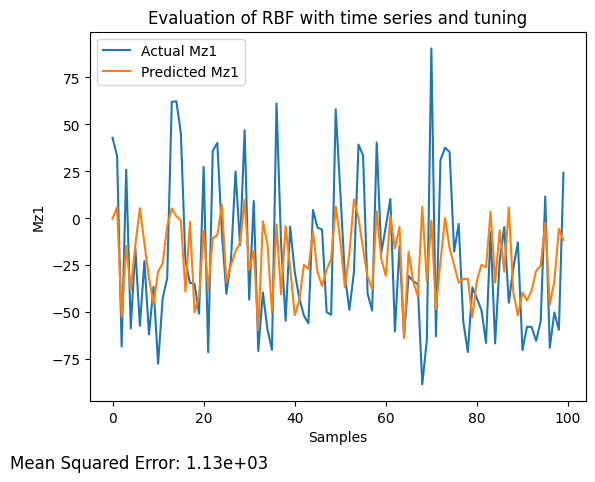

In [7]:
# Evaluate the model
timeframe = 100
final_pred = scaler_y.inverse_transform(y_pred)[:, 1][:timeframe]
final_test = scaler_y.inverse_transform(y_test)[:timeframe, 0]
# Pick a random MSE because I suppose you want the smallest one but whatever.
src.plots.evaluate_predictions(final_pred, final_test, mean_squared_error(final_pred, final_test), name="RBF with time series and tuning")